# Healthy Personalized Food Recommender System Using Two-Tower Deep Neural Network

# Motivation

Recommender systems are designed to assist users in discovering relevant items by analyzing their preferences and generating a tailored list of suggestions. These systems effectively address the problem of choice overload, enabling users to navigate through vast amount of options with ease. By accurately predicting user preferences, recommender systems enhance user experience and satisfaction. They are widely employed across various domains, offering personalized recommendations that cater to individual needs and interest.
Recommender system employs three different approaches to generate recommendations, collaborative filtering, content based filtering and hybrid approach.


In the domain of food, recommender systems are utilized in various contexts such as restaurant suggestions, grocery store item personalization, and recipe recommendations. Creating an accurate food recommender system is complex due to the multifaceted nature of the food domain, which involves context, location, health preferences, and more.


## Problem Formulation

Deciding what and where to eat is challenging due to the vast array of available options. Online food recommender systems aim to help users find relevant food items and recipes. However, previous studies show that these systems often promote unhealthy food choices. This is primarily due to user-generated content that favors unhealthy options and the use of datasets that do not comply with health metrics like the Food Standards Agency (FSA) score and World Health Organization (WHO) guidelines.

The goal of this project is to develop a ranking food recommender system that suggests top recipe recommendations. A subsequent healthiness filter will rank these recommendations based on the healthiness of the recipes, using the FSA score. The recommendation generation will be based on the well-known Two-Tower architecture, a popular deep learning approach for building recommender systems.


The proposed model will be evaluated against a baseline: a traditional Singular Value Decomposition (SVD) collaborative filtering model. User recipe ratings will be used to assess the effectiveness of both models.

The future application of this project will involve conducting a user study to provide personalized recommendations using the Two-Tower deep learning model to predict personalized recipes according to each user preference and features. A healthiness filter algorithm will select the healthiest recipes to present to users. The key evaluative question will be:

To what extent does a highly personalized recommender system nudge users toward healthier food choices?

This notebook is organized into the following sections:

- **Dataset:** Overview of the dataset used to train the model
- **Model Architecture:** Details of the Two-Tower deep neural network
- **SVD Baseline:** Description of the baseline collaborative filtering model
- **Evaluation:** Results and evaluations of the developed models

## Dataset

The dataset that we will use in this project is collected during the course line of my PhD project and the user experiments that we condactated as mean to evaluate our propesed recommender systems and digital nudges. The dataset collected from several experiments that can found :

- [ [1] Nudging Towards Health? Examining the Merits of Nutrition
Labels and Personalization in a Recipe Recommender System](https://dl.acm.org/doi/pdf/10.1145/3503252.3531312)
- [ [2] Boosting Health? Examining the Role of Nutrition
Labels and Preference Elicitation Methods in Food
Recommendation](https://edepot.wur.nl/579903)
- [ [3] The Interplay between Food Knowledge, Nudges, and
Preference Elicitation Methods Determines the
Evaluation of a Recipe Recommender System](https://ceur-ws.org/Vol-3534/paper1.pdf)
- [ [4] Nudging towards sustainable recipes: Nudging towards sustainable recipes, Internal project]()


### Data Preparation and EDA

- The dataset is from different projects and the main idea is to construct training data from the previously collected data: user features dataset and a dataframe that describes recipe features.
- The main goal is to learn models to construct user embedding and recipe embedding that will be used later to compute a Cosine  similarity to find the best recipes for user 

In [579]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### User Features
Construct a user training dataset that describes each user through various features, derived by combining different dataframes from the above projects.

In [379]:
##  user data from Nudging towards healthy food choice [1]
nudge_pers_df = pd.read_csv('./Dataset/Nudging_personalization.csv')

## user data from Boosting healthy [2]
boosting_heal_df = pd.read_csv('./Dataset/PE_boost_nudge_study.csv')

## user data from Interplay between food knowledge and preference elicitation [3]
preference_user_df = pd.read_csv('./Dataset/PE_elicitation.csv')

## sustainability data [4]
sustainability_user_id = pd.read_csv('./Dataset/Sustainability_data.csv')

- Select useful features from each DF

In [383]:
## DF [1]
nudge_pers_df = nudge_pers_df[['person','age','country','education','diet_restriction','diet_goal',
                               'cooking_exp','eating_habits','gender','recipe_name']]
nudge_pers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   person            300 non-null    int64 
 1   age               300 non-null    object
 2   country           300 non-null    object
 3   education         300 non-null    object
 4   diet_restriction  300 non-null    object
 5   diet_goal         300 non-null    object
 6   cooking_exp       300 non-null    object
 7   eating_habits     300 non-null    object
 8   gender            300 non-null    object
 9   recipe_name       300 non-null    object
dtypes: int64(1), object(9)
memory usage: 23.6+ KB


In [384]:
## DF [2]
boosting_heal_df = boosting_heal_df[['person','age','country','education','gender','recipe_name']]
boosting_heal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   person       243 non-null    int64 
 1   age          243 non-null    object
 2   country      243 non-null    object
 3   education    243 non-null    object
 4   gender       243 non-null    object
 5   recipe_name  243 non-null    object
dtypes: int64(1), object(5)
memory usage: 11.5+ KB


In [385]:
## DF [3]
preference_user_df = preference_user_df[['person','age','country','education','gender','recipe_name','Height',
                                         'Weight','RecipeWebUsage','HomeCook','CookingExp',
                                         'EatingGoals','Depression','PhysicalActivity','SleepHours',
                                         'CookingTime']]
preference_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            360 non-null    int64  
 1   age               360 non-null    object 
 2   country           360 non-null    object 
 3   education         360 non-null    object 
 4   gender            360 non-null    object 
 5   recipe_name       360 non-null    object 
 6   Height            180 non-null    float64
 7   Weight            180 non-null    float64
 8   RecipeWebUsage    180 non-null    object 
 9   HomeCook          180 non-null    object 
 10  CookingExp        180 non-null    object 
 11  EatingGoals       180 non-null    object 
 12  Depression        180 non-null    object 
 13  PhysicalActivity  180 non-null    object 
 14  SleepHours        180 non-null    object 
 15  CookingTime       180 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory u

In [386]:
## DF [4]
sustainability_user_id = sustainability_user_id[['person','age','country','education','gender',
                                 'recipe_name','diet_restriction','diet_goal','cooking_exp','eating_habits']]
sustainability_user_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   person            200 non-null    int64 
 1   age               200 non-null    object
 2   country           200 non-null    object
 3   education         200 non-null    object
 4   gender            200 non-null    object
 5   recipe_name       200 non-null    object
 6   diet_restriction  200 non-null    object
 7   diet_goal         200 non-null    object
 8   cooking_exp       200 non-null    object
 9   eating_habits     200 non-null    object
dtypes: int64(1), object(9)
memory usage: 15.8+ KB


In [387]:
## User Dataset concatenation based on user id (person)

# change the user_id to avoid intersection of different person
boosting_heal_df[['person']] = boosting_heal_df[['person']] + nudge_pers_df[['person']].max() + 1000
preference_user_df[['person']] = preference_user_df[['person']] + boosting_heal_df[['person']].max() + 1000
sustainability_user_id[['person']] = sustainability_user_id[['person']] + preference_user_df[['person']].max() + 1000

In [391]:
## to avoid intersection between different user 
print(f'nudge DF min id {nudge_pers_df.person.min()} , nudge DF max id {nudge_pers_df.person.max()}')
print(f'boosting DF min id {boosting_heal_df.person.min()}, boost DF max id {boosting_heal_df.person.max()}')
print(f'sustainability DF min id {sustainability_user_id.person.min()}, sustainability DF max id {sustainability_user_id.person.max()}')

nudge DF min id 4 , nudge DF max id 2132
boosting DF min id 3148, boost DF max id 8204
sustainability DF min id 14275, sustainability DF max id 16385


In [392]:
### concatenate all user data to construct user DataFrame
user_features_DF = pd.concat([nudge_pers_df, boosting_heal_df, sustainability_user_id], axis=0, ignore_index=True)
user_features_DF.to_csv('./Dataset/user_features_df.csv', index=False)

- Fill NAN features

In [396]:
user_features_DF.isna().sum()

person                0
age                   0
country               0
education             0
diet_restriction    243
diet_goal           243
cooking_exp         243
eating_habits       243
gender                0
recipe_name           0
dtype: int64

- Deal with nan values using meadium and neutral habits

In [397]:
user_features_DF[['diet_restriction','diet_goal','cooking_exp','eating_habits']]

,diet_restriction,diet_goal,cooking_exp,eating_habits
0,No dietary restrictions,No goals,Low,Unhealthy
1,No dietary restrictions,"Eat less salt,Eat less sugar,Eat more fruit,Ea...",Medium,Neither_healthy_no_unhealthy
2,No dietary restrictions,Lose weight,Low,Neither_healthy_no_unhealthy
3,No dietary restrictions,No goals,High,Neither_healthy_no_unhealthy
4,No dietary restrictions,Eat more fruit,High,Healthy
...,...,...,...,...
738,['Lactose intolerance'],['Lose weight'],Medium,Very_unhealthy
739,['No dietary restrictions'],"['Eat less salt', ' Gain weight']",Medium,Unhealthy
740,"['Lactose intolerance', ' Vegetarian']","['No goals', ' Eat more fruit', ' Eat more pro...",High,Healthy
741,"['Gluten free', ' Lactose intolerance']",['No goals'],Low,Very_unhealthy


In [398]:
## Replace Na values
## assuming that all users will have neutral value of features with NA
user_features_DF.fillna(
    {
    'diet_restriction':'No dietary restrictions',
    'diet_goal'       :'No goals',
    'cooking_exp'     : 'Medium',
    'eating_habits'    :'Neither_healthy_no_unhealthy',
    }
, inplace=True)

In [399]:
user_features_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   person            743 non-null    int64 
 1   age               743 non-null    object
 2   country           743 non-null    object
 3   education         743 non-null    object
 4   diet_restriction  743 non-null    object
 5   diet_goal         743 non-null    object
 6   cooking_exp       743 non-null    object
 7   eating_habits     743 non-null    object
 8   gender            743 non-null    object
 9   recipe_name       743 non-null    object
dtypes: int64(1), object(9)
memory usage: 58.2+ KB


In [401]:
# create a new id for the recipes that the user has chosen
user_features_DF['user_id'] = user_features_DF['person']
user_features_DF['recipe_id'] = pd.Categorical(user_features_DF['recipe_name']).codes
user_features_DF.head()

,person,age,country,education,diet_restriction,diet_goal,cooking_exp,eating_habits,gender,recipe_name,user_id,recipe_id
0,4,b35_45,US,BA,No dietary restrictions,No goals,Low,Unhealthy,Male,Ray's Chicken,4,128
1,5,b25_35,US,High_school,No dietary restrictions,"Eat less salt,Eat less sugar,Eat more fruit,Ea...",Medium,Neither_healthy_no_unhealthy,Male,Sarge's EZ Pulled Pork BBQ,5,141
2,6,b35_45,US,BA,No dietary restrictions,Lose weight,Low,Neither_healthy_no_unhealthy,Male,Bow Ties with Sausage' Tomatoes and Cream,6,28
3,7,b25_35,US,High_school,No dietary restrictions,No goals,High,Neither_healthy_no_unhealthy,Male,Scott Hibb's Amazing Whisky Grilled Baby Back ...,7,143
4,9,b25_35,US,BA,No dietary restrictions,Eat more fruit,High,Healthy,Female,Pizza Without the Red Sauce,9,121


In [403]:
## save the data for later use
user_features_DF.to_csv('./Dataset/user_feature.csv', index=False)

- The target is the chosen recipes by the user, we want to learn user feature and recipes feature that will lead to the choice

In [404]:
# extract unique selected recipes by the user
target_recipe = pd.DataFrame(user_features_DF['recipe_name'].unique(), columns=['recipes'])
target_recipe

,recipes
0,Ray's Chicken
1,Sarge's EZ Pulled Pork BBQ
2,Bow Ties with Sausage' Tomatoes and Cream
3,Scott Hibb's Amazing Whisky Grilled Baby Back ...
4,Pizza Without the Red Sauce
...,...
184,Chicken In Basil Cream
185,Rosemary Lemon Grilled Chicken
186,Beef Bulgogi
187,Honey Garlic Ribs


- Create (label) a column that indicate if user interact with a recipe or not, 1 if the user choses the recipes, 0 if not

In [405]:
users = user_features_DF['user_id'].unique()
recipes = user_features_DF['recipe_id'].unique()

# Identify interacted pairs
interacted_pairs = user_features_DF.groupby(['user_id', 'recipe_id']).size().reset_index(name='chosen')

all_users = set(user_features_DF['user_id'].unique())
all_recipes = set(user_features_DF['recipe_id'].unique())
all_pairs = pd.DataFrame([(user_id, recipe_id) for user_id in all_users for recipe_id in all_recipes],
                         columns=['user_id', 'recipe_id'])

# Merge to fill in missing chosens with 0
interaction_Df = pd.merge(all_pairs, interacted_pairs, on=['user_id', 'recipe_id'], how='left').fillna(0)

In [406]:
interaction_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140427 entries, 0 to 140426
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    140427 non-null  int64  
 1   recipe_id  140427 non-null  int16  
 2   chosen     140427 non-null  float64
dtypes: float64(1), int16(1), int64(1)
memory usage: 2.4 MB


In [407]:
# Merge with  all user features
user_features_DF = user_features_DF.merge(interaction_Df, on='user_id')

In [408]:
user_features_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140427 entries, 0 to 140426
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            140427 non-null  int64  
 1   age               140427 non-null  object 
 2   country           140427 non-null  object 
 3   education         140427 non-null  object 
 4   diet_restriction  140427 non-null  object 
 5   diet_goal         140427 non-null  object 
 6   cooking_exp       140427 non-null  object 
 7   eating_habits     140427 non-null  object 
 8   gender            140427 non-null  object 
 9   recipe_name       140427 non-null  object 
 10  user_id           140427 non-null  int64  
 11  recipe_id_x       140427 non-null  int16  
 12  recipe_id_y       140427 non-null  int16  
 13  chosen            140427 non-null  float64
dtypes: float64(1), int16(2), int64(2), object(9)
memory usage: 13.4+ MB


In [409]:
user_features_DF.drop(columns = ['recipe_id_y','person'], inplace=True)
user_features_DF.rename(columns = {'recipe_id_x':'recipe_id'}, inplace=True)

#### Recipe Features
Construct a training dataset that describes each recipe using various features. The original dataset, primarily sourced from Allrecipes.com, serves as the basis for our research.

In [410]:
## read original recipes
source_recipes = pd.read_csv('./Dataset/recipe_source.csv')
source_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   URL                 942 non-null    object 
 1   Name                942 non-null    object 
 2   fiber_g             942 non-null    float64
 3   sodium_g            942 non-null    float64
 4   carbohydrates_g     942 non-null    float64
 5   fat_g               942 non-null    float64
 6   protein_g           942 non-null    float64
 7   sugar_g             942 non-null    float64
 8   saturate_g          942 non-null    float64
 9   size_g              942 non-null    float64
 10  Servings            942 non-null    int64  
 11  calories_kCal       942 non-null    int64  
 12  category            942 non-null    object 
 13  image_link          942 non-null    object 
 14  fat_100g            942 non-null    float64
 15  fiber_100g          942 non-null    float64
 16  sugar_10

In [411]:
## extract features for selected recipes by users
recip_features_df  = pd.merge(source_recipes, target_recipe, right_on = 'recipes', left_on='Name')

# check if all selected recipes by users are in the orignal recipe dataset
target_recipe.recipes.isin(source_recipes.Name).any()


True

In [412]:
# drop useless columns
source_recipes.drop(columns = ['URL','image_link'], inplace=True)

In [413]:
# rename a column
source_recipes.rename(columns={'Name':'recipe_name'}, inplace=True)

In [414]:
## final recipe dataset
source_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recipe_name         942 non-null    object 
 1   fiber_g             942 non-null    float64
 2   sodium_g            942 non-null    float64
 3   carbohydrates_g     942 non-null    float64
 4   fat_g               942 non-null    float64
 5   protein_g           942 non-null    float64
 6   sugar_g             942 non-null    float64
 7   saturate_g          942 non-null    float64
 8   size_g              942 non-null    float64
 9   Servings            942 non-null    int64  
 10  calories_kCal       942 non-null    int64  
 11  category            942 non-null    object 
 12  fat_100g            942 non-null    float64
 13  fiber_100g          942 non-null    float64
 14  sugar_100g          942 non-null    float64
 15  saturated_100g      942 non-null    float64
 16  protien_

In [418]:
## add recipe feature to the user data  final train_test set for the user 
user_recipe_DF = source_recipes.merge(user_features_DF, on='recipe_name')

In [419]:
## select only recipe features 
source_recipes_final_DF = user_recipe_DF.drop(columns =['age', 'country', 'education', 'diet_restriction', 'diet_goal',
       'cooking_exp', 'eating_habits', 'gender', 'user_id',
       'recipe_id'])

In [421]:
# save for later use
source_recipes_final_DF.to_csv('./Dataset/recipes_df_f.csv', index=False)

## Two Tower Model
A Two-Tower Recommender System is a hybrid recommender model that integrates collaborative filtering and content-based methods. It utilizes two deep neural networks—one for users and one for items—to embed them into a shared low-dimensional space. The system then predicts user preferences or ratings for items based on the geometric relationships between these embeddings, using metrics such as cosine similarity or dot product. By leveraging both user-item interactions and the intrinsic features of users and items, the two-tower approach provides more accurate and personalized recommendations.
Figure below shows the two tower



<p align="center">
  <img src="final_project.png" alt="Two-Tower Model" width="450"/>
</p>

The two-tower model will be implemented Pytorch

In [173]:
## Import libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from typing import List
from torch.utils.data import DataLoader, TensorDataset, Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

### Prepare user and recipe training Data

In [427]:
user  = user_recipe_DF
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138726 entries, 0 to 138725
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   recipe_name         138726 non-null  object 
 1   fiber_g             138726 non-null  float64
 2   sodium_g            138726 non-null  float64
 3   carbohydrates_g     138726 non-null  float64
 4   fat_g               138726 non-null  float64
 5   protein_g           138726 non-null  float64
 6   sugar_g             138726 non-null  float64
 7   saturate_g          138726 non-null  float64
 8   size_g              138726 non-null  float64
 9   Servings            138726 non-null  int64  
 10  calories_kCal       138726 non-null  int64  
 11  category            138726 non-null  object 
 12  fat_100g            138726 non-null  float64
 13  fiber_100g          138726 non-null  float64
 14  sugar_100g          138726 non-null  float64
 15  saturated_100g      138726 non-nul

In [428]:
## remove useless features and nan ones
user.drop(columns=['user_id','recipe_id', 'protien_100g'], inplace=True)

In [429]:
recipe  = source_recipes_final_DF
recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138726 entries, 0 to 138725
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   recipe_name         138726 non-null  object 
 1   fiber_g             138726 non-null  float64
 2   sodium_g            138726 non-null  float64
 3   carbohydrates_g     138726 non-null  float64
 4   fat_g               138726 non-null  float64
 5   protein_g           138726 non-null  float64
 6   sugar_g             138726 non-null  float64
 7   saturate_g          138726 non-null  float64
 8   size_g              138726 non-null  float64
 9   Servings            138726 non-null  int64  
 10  calories_kCal       138726 non-null  int64  
 11  category            138726 non-null  object 
 12  fat_100g            138726 non-null  float64
 13  fiber_100g          138726 non-null  float64
 14  sugar_100g          138726 non-null  float64
 15  saturated_100g      138726 non-nul

In [493]:
## remove useless features and nan ones
recipe.drop(columns=['protien_100g',], inplace=True)

- The label for a recipe will be based on FSA score that indicate the healthiness of recipe, FSA < 7 healthy and FSA > 7 unhealthy

In [494]:
recipe['healthiness'] = 1
recipe.loc[recipe.Fsa_new > 7, 'healthiness'] = 0

- Convert categorical Data into numerical

In [495]:
from sklearn.preprocessing import LabelEncoder

# List of categorical features
user_categorical_columns = [
     'country','age','gender', 'education', 'diet_restriction', 'diet_goal',
    'cooking_exp', 'eating_habits', 'recipe_name',
     'category', 'Nutri_score'
]

recipe_categorical_columns = ['recipe_name','Nutri_score','category']

# Choose whether to use Label Encoding or One-Hot Encoding
use_label_encoding = True  # Set to False for One-Hot Encoding



# Apply Label Encoding
for col in user_categorical_columns:
    le = LabelEncoder()
    user[col] = le.fit_transform(user[col])
    label_encoders[col] = le  # Save the encoder for later use

# Apply Label Encoding
for col in recipe_categorical_columns:
    le = LabelEncoder()
    recipe[col] = le.fit_transform(recipe[col])
    label_encoders[col] = le  # Save the encoder for later use

In [496]:
## user data
user.head()

,recipe_name,fiber_g,sodium_g,carbohydrates_g,fat_g,protein_g,sugar_g,saturate_g,size_g,Servings,...,NumberRatings,age,country,education,diet_restriction,diet_goal,cooking_exp,eating_habits,gender,chosen
0,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,731,4,6,2,37,21,2,1,0,0.0
1,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,731,4,6,2,37,21,2,1,0,0.0
2,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,731,4,6,2,37,21,2,1,0,0.0
3,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,731,4,6,2,37,21,2,1,0,0.0
4,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,731,4,6,2,37,21,2,1,0,0.0


In [497]:
# recipe data
recipe.head()

,recipe_name,fiber_g,sodium_g,carbohydrates_g,fat_g,protein_g,sugar_g,saturate_g,size_g,Servings,...,Fsa_new,salt_100g,salt_g,fat_count,satfat_count,sugar_count,salt_count,NumberRatings,chosen,healthiness
0,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,8,1.12415,1.6002,2,2,2,2,731,0.0,0
1,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,8,1.12415,1.6002,2,2,2,2,731,0.0,0
2,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,8,1.12415,1.6002,2,2,2,2,731,0.0,0
3,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,8,1.12415,1.6002,2,2,2,2,731,0.0,0
4,109,0.1,0.63,14.1,12.4,23.2,11.9,2.5,569.39,4,...,8,1.12415,1.6002,2,2,2,2,731,0.0,0


- As we see we need to normalize the data for comparability between feature using min_max Normalizer

In [499]:
# define normalizer function

def min_max_normalization(data):
    min_vals = torch.min(data, dim=0)[0]
    max_vals = torch.max(data, dim=0)[0]
    normalized = (data - min_vals) / (max_vals - min_vals + 1e-6)  # Add small epsilon to avoid division by zero
    return normalized

- Convert user and recipe data into vectors

In [500]:
## user vector
X_user = torch.tensor(user.drop('chosen', axis = 1).values, dtype=torch.float)
y_user = torch.tensor(
    user.chosen.values, dtype=torch.long
)

print(X_user.shape)
print(y_user.shape)

torch.Size([138726, 36])
torch.Size([138726])


In [501]:
# recipe vector
X_recipe = torch.tensor(recipe.drop('healthiness', axis = 1).values, dtype=torch.float)
y_recipe = torch.tensor(
    recipe.healthiness.values, dtype=torch.long
)

print(X_recipe.shape)
print(y_recipe.shape)

torch.Size([138726, 29])
torch.Size([138726])


- Split data into training and testing 

In [502]:
## User train/test split

X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(X_user, y_user, train_size = 0.8, random_state=42)

X_train_user = min_max_normalization (X_train_user)
X_test_user = min_max_normalization (X_test_user)

train_data_user = TensorDataset(X_train_user, y_train_user)
test_data_user = TensorDataset(X_test_user, y_test_user)

train_loader_user = DataLoader(train_data_user, shuffle=True, batch_size=32)
test_loader_user = DataLoader(test_data_user, batch_size=len(test_data_user.tensors[0]))


In [503]:
## recipe train/test split 

X_train_recipe, X_test_recipe, y_train_recipe, y_test_recipe = train_test_split(X_recipe, y_recipe, train_size = 0.8, random_state=42)

X_train_recipe = min_max_normalization (X_train_recipe)
X_test_recipe = min_max_normalization (X_test_recipe)

train_data_recipe = TensorDataset(X_train_recipe, y_train_recipe)
test_data_recipe = TensorDataset(X_test_recipe, y_test_recipe)

train_loader_recipe = DataLoader(train_data_recipe, shuffle=True, batch_size=32)
test_loader_recipe = DataLoader(test_data_recipe, batch_size=len(test_data_user.tensors[0]))

#### User and recipe Neural Network architecture  

In [544]:
# User tower

class UserTower(nn.Module):
    def __init__(self):
        super(UserTower, self).__init__()
        self.fc1 = nn.Linear(36, 64)  # fist layer
        self.fc2 = nn.Linear(64, 128)
        self.layer_norm1 = nn.LayerNorm(64)   # layer normalization for first hidden layer
        self.layer_norm2 = nn.LayerNorm(128)
        self.output = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.layer_norm1(self.fc1(x))) # Apply BatchNorm and ReLU to the first hidden layer
        x = F.relu(self.layer_norm2(self.fc2(x))) # Apply BatchNorm and ReLU to the first hidden layer
        x = self.output(x)
        x = self.softmax(x)
        return x

# Recipe Tower
        
class RecipeTower(nn.Module):
    def __init__(self):
        super(RecipeTower, self).__init__()
        self.fc1 = nn.Linear(29, 64)  # fist layer
        self.fc2 = nn.Linear(64, 128)
        self.layer_norm1 = nn.LayerNorm(64)   # layer normalization for first hidden layer
        self.layer_norm2 = nn.LayerNorm(128)
        self.output = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.layer_norm1(self.fc1(x))) # Apply BatchNorm and ReLU to the first hidden layer
        x = F.relu(self.layer_norm2(self.fc2(x))) # Apply BatchNorm and ReLU to the first hidden layer
        x = self.output(x)
        x = self.softmax(x)
        return x       
        
        

- Define hyperparameters

In [505]:
 num_epochs = 10
 learning_rate = 0.001
 criterion = nn.CrossEntropyLoss()  ## loss function

- Train the user model

In [506]:
user_model = UserTower()
optimizer = optim.Adam(user_model.parameters(), lr=0.001)

In [477]:
for epoch in range(num_epochs):
    user_model.train()  # Ensure the user_mode is in training mode
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training phase
    for data, target in train_loader_user:
        optimizer.zero_grad()  # Zero the gradients
        output = user_model(data)  # Forward pass
        loss = criterion(output, target)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Accumulate loss
        total_loss += loss.item()
        
        # Calculate the accuracy
        _, predicted = torch.max(output.data, 1)  # Get the class with the highest score
        total_train += target.size(0)  # Total number of samples
        correct_train += (predicted == target).sum().item()  # Count correct predictions
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader_user)
    train_accuracy = 100 * correct_train / total_train

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


Epoch 1/10, Loss: 0.3188, Accuracy: 99.47%
Epoch 2/10, Loss: 0.3185, Accuracy: 99.48%
Epoch 3/10, Loss: 0.3185, Accuracy: 99.48%
Epoch 4/10, Loss: 0.3185, Accuracy: 99.48%
Epoch 5/10, Loss: 0.3185, Accuracy: 99.48%
Epoch 6/10, Loss: 0.3185, Accuracy: 99.48%
Epoch 7/10, Loss: 0.3185, Accuracy: 99.48%
Epoch 8/10, Loss: 0.3185, Accuracy: 99.48%
Epoch 9/10, Loss: 0.3185, Accuracy: 99.48%
Epoch 10/10, Loss: 0.3185, Accuracy: 99.48%


Due to imbalanced classed in our dataset the model is not learning in a better way (using the Synthetic dataset in future works)

- train the recipe model

In [511]:
recipe_model = RecipeTower()
optimizer = optim.Adam(recipe_model.parameters(), lr=0.001)

In [512]:
for epoch in range(num_epochs):
    recipe_model.train()  # Ensure the user_mode is in training mode
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training phase
    for data, target in train_loader_recipe:
        optimizer.zero_grad()  # Zero the gradients
        output = recipe_model(data)  # Forward pass
        loss = criterion(output, target)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Accumulate loss
        total_loss += loss.item()
        
        # Calculate the accuracy
        _, predicted = torch.max(output.data, 1)  # Get the class with the highest score
        total_train += target.size(0)  # Total number of samples
        correct_train += (predicted == target).sum().item()  # Count correct predictions
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader_user)
    train_accuracy = 100 * correct_train / total_train

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


Epoch 1/10, Loss: 0.3161, Accuracy: 99.74%
Epoch 2/10, Loss: 0.3133, Accuracy: 100.00%
Epoch 3/10, Loss: 0.3133, Accuracy: 100.00%
Epoch 4/10, Loss: 0.3133, Accuracy: 100.00%
Epoch 5/10, Loss: 0.3133, Accuracy: 100.00%
Epoch 6/10, Loss: 0.3133, Accuracy: 100.00%
Epoch 7/10, Loss: 0.3133, Accuracy: 100.00%
Epoch 8/10, Loss: 0.3133, Accuracy: 100.00%
Epoch 9/10, Loss: 0.3133, Accuracy: 100.00%
Epoch 10/10, Loss: 0.3133, Accuracy: 100.00%


#### Load the embedding from trained model

In [545]:
## user model
torch.save(user_model.state_dict(), './models/user_model')

## recipe model
torch.save(recipe_model.state_dict(), './models/recipe_model')

In [550]:
## Load the user embeedings
user_model = UserTower()
user_model.load_state_dict(torch.load('./models/user_model'),strict=False)
user_model.eval()

UserTower(
  (fc1): Linear(in_features=36, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)

In [551]:
## Load the recipe embeedings
recipe_model = RecipeTower()
recipe_model.load_state_dict(torch.load('./models/recipe_model'),strict=False)
recipe_model.eval()

RecipeTower(
  (fc1): Linear(in_features=29, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)

- Test and compute the dot product between one user embedding and one recipe embedding

In [552]:
# Example of user embedding based on the trained model

single_user_example = next(iter(train_loader_user))  
user_embeddings = user_model(single_user_example[0][0].unsqueeze(0))
print("User learned Embeddings:\n", user_embeddings)

User learned Embeddings:
 tensor([[0.2513, 0.0000, 0.3262, 0.0000, 0.0000, 0.5155, 2.3360, 1.4501, 0.5101,
         0.0000, 0.3808, 1.9840, 0.6948, 0.0000, 0.4033, 0.0000, 0.1640, 0.0000,
         1.4082, 0.0000, 0.0000, 0.0000, 0.0000, 1.0802, 0.0000, 1.8261, 0.8042,
         0.2545, 0.0000, 0.0000, 0.9226, 0.0000, 0.0000, 0.0000, 0.0000, 0.6176,
         0.1837, 0.0000, 0.0857, 0.0000, 0.3789, 0.0000, 1.0647, 0.6398, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.6466, 0.9221, 0.0000, 0.7049, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0135, 1.2175, 1.7723, 0.9298, 1.9760,
         0.0000, 0.0000, 0.0000, 0.3689, 0.0000, 0.0000, 0.7835, 1.4558, 0.0911,
         0.0000, 0.0000, 0.8336, 1.2056, 0.0000, 0.0000, 0.0000, 0.6112, 0.0000,
         0.0000, 0.0000, 0.0989, 0.0000, 0.2973, 1.0233, 0.0000, 0.1779, 1.1998,
         0.0000, 0.0000, 0.0000, 0.9199, 0.0000, 0.0101, 0.0862, 0.0000, 0.3142,
         0.1515, 0.0000, 1.1285, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1025,
  

In [557]:
# Example of recipe embedding based on the trained model

first_recipe_example = next(iter(train_loader_recipe))  
first_recipe_embeddings = recipe_model(first_recipe_example[0][0].unsqueeze(0))
print("Recipe learned Embeddings:\n", first_recipe_embeddings)


second_recipe_example = next(iter(train_loader_recipe))  
second_recipe_embeddings = recipe_model(seconmd_recipe_example[0][1].unsqueeze(0))
print("Recipe learned Embeddings:\n", second_recipe_embeddings)

Recipe learned Embeddings:
 tensor([[0.0000, 0.0000, 0.0000, 1.0695, 0.0000, 0.0000, 0.0000, 0.5646, 0.0000,
         1.3107, 0.0000, 0.0000, 0.4677, 2.4392, 0.0000, 2.3479, 3.6468, 0.9085,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4236, 0.0000, 0.0000, 2.6997,
         1.9106, 0.0000, 0.0000, 0.2539, 0.0000, 0.0000, 1.9564, 0.0000, 1.5905,
         0.1131, 0.8354, 0.0000, 0.0000, 1.1444, 0.0000, 2.7525, 2.3657, 1.1543,
         1.4744, 0.0000, 0.0000, 0.8581, 0.0471, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0670, 0.0000, 0.5394,
         0.0000, 0.0000, 2.3148, 0.0000, 0.6323, 1.6289, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 2.4514, 0.8972, 0.0000, 0.0000, 2.2440, 1.3374, 0.0000,
         0.0000, 0.4854, 1.2260, 0.0000, 1.2671, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.8876, 2.5509, 0.0363, 0.0000, 2.1515,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,


- After we got the embedding from learned models of the user and the recipe, for a given user we will compute the consine similiary to retrive the most relevant recipe for that user.
- This idea will be implemented in a user experiment 


In [563]:
# example of computing consine simlarities between the first user and two recipes

user_1_recipe_1_similarity = F.cosine_similarity(user_embeddings, first_recipe_embeddings)


print(f"Cosine Similarity between user 1 and first recipe 1: {user_1_recipe_1_similarity.item()}")


user_1_recipe_2_similarity = F.cosine_similarity(user_embeddings, second_recipe_embeddings)

print(f"Cosine Similarity between user 1 and second recipe 1: {user_1_recipe_2_similarity.item()}")

Cosine Similarity between user 1 and first recipe 1: 0.2607012391090393
Cosine Similarity between user 1 and second recipe 1: 0.26669514179229736


# Second Part: Matrix Factorization using SVD

Matrix factorization is a class of collaborative filtering algorithms. Matrix factorization is a simple embedding model, and the idea behind it is to decompose the user-item matrix into tow lower-rank matrices: one that represents the users preference and one that represents the items characteristics. The user-item matrix is then reconstructed by taking the dot product of these two matrices. Figure bellow shows and example of a matrix factorization:

<p align="center">
  <img src="MF.png" alt="MF" width="450"/>
</p>

Each row represents a user and each column represents an item. The entries of the matrix are the ratings that the users gave to the items. However, the matrix is usually very sparse because each user has only rated a small fraction of the items.

The matrix factorization aims to factorize the user-item matrix $R$ into two lower-rank matrices $P$ and $Q$, such that their product approximates $R$. The matrix $P$ represents the users' preferences and the matrix $Q$ represents the items characteristics. Each row of the matrix $P$ represents a users preferences as a vector, and each row of the matrix $Q$ represents an items characteristics as a vector.



- In this part I will compare several MF algorithms to select the best one, to be implemented in comparaison with Two-tower generate embedding model.

### The Dataset

- The dataset to be used in this part is from Allrecipes.com website, and contain the essential features for the matrix factorization task including, the user, the recipes and the rating provided by the user to the recipes

In [609]:
# read recipe dataset
recipe_data = pd.read_csv('./Dataset/recipes_original.csv')
recipe_data.head()

,id,URL,Name,category,Size,Serving,Calories,AverageRatings,Ratings,image_link
0,1,http://allrecipes.com/recipe/pineapple-grilled...,Pineapple Grilled Pork Chops,Barbecue,1084.69,4,392,4.65,68,http://images.media-allrecipes.com/userphotos/...
1,2,http://allrecipes.com/recipe/scott-hibbs-amazi...,Scott Hibb's Amazing Whisky Grilled Baby Back ...,Barbecue,2799.41,4,1043,4.78,261,http://images.media-allrecipes.com/userphotos/...
2,3,http://allrecipes.com/recipe/easy-chicken-sata...,Easy Chicken Satay,Barbecue,1110.24,5,418,4.73,80,http://images.media-allrecipes.com/userphotos/...
3,4,http://allrecipes.com/recipe/big-smokey-burger...,Big Smokey Burgers,Barbecue,1556.18,6,537,4.52,50,http://images.media-allrecipes.com/userphotos/...
4,5,http://allrecipes.com/recipe/firecracker-grill...,Firecracker Grilled Alaska Salmon,Barbecue,1201.10,8,307,4.76,242,http://images.media-allrecipes.com/userphotos/...


In [567]:
## rating data for recipes 
prf1 = pd.read_csv('./Dataset/item-profiles1.csv', sep=';')
prf2 = pd.read_csv('./Dataset/item-profiles2.csv',sep=';')
prf3 = pd.read_csv('./Dataset/item-profiles3.csv',sep=';')

- Merge the data to user_id and recipes id 

In [599]:
prf2 = prf2[['Recipe ID', 'Name']]
prf3 = prf3[['Recipe ID']]
# merge the tow data
recipes_df = prf2.merge(prf3, on='Recipe ID')
recipes_df.rename(columns={'Recipe ID':'recipeID'}, inplace=True)
recipes_df.head()

,recipeID,Name
0,2622,Slow Cooker Tender and Yummy Round Steak
1,2622,Slow Cooker Tender and Yummy Round Steak
2,2622,Slow Cooker Tender and Yummy Round Steak
3,2622,Slow Cooker Tender and Yummy Round Steak
4,2622,Slow Cooker Tender and Yummy Round Steak


- read data that contain user, recipe, rating

In [582]:
# data with rating
headers = ['userID','recipeID', 'rating']
user_recipe_rating = pd.read_csv('./Dataset/user-item-rating.csv', sep='\t', names = headers)

user_recipe_rating.head()

,userID,recipeID,rating
0,455,50,3.0
1,455,457,4.0
2,455,28,5.0
3,455,458,3.0
4,455,459,5.0


- Merge ratings and recipe names

In [606]:
final_set = user_recipe_rating.merge(recipes_df, on='recipeID')
print('#items',len(final_set))
final_set.head()

#items 463795


,userID,recipeID,rating,Name
0,455,50,3.0,Baked Ziti I
1,455,50,3.0,Baked Ziti I
2,455,50,3.0,Baked Ziti I
3,455,50,3.0,Baked Ziti I
4,455,50,3.0,Baked Ziti I


- Rating distributions

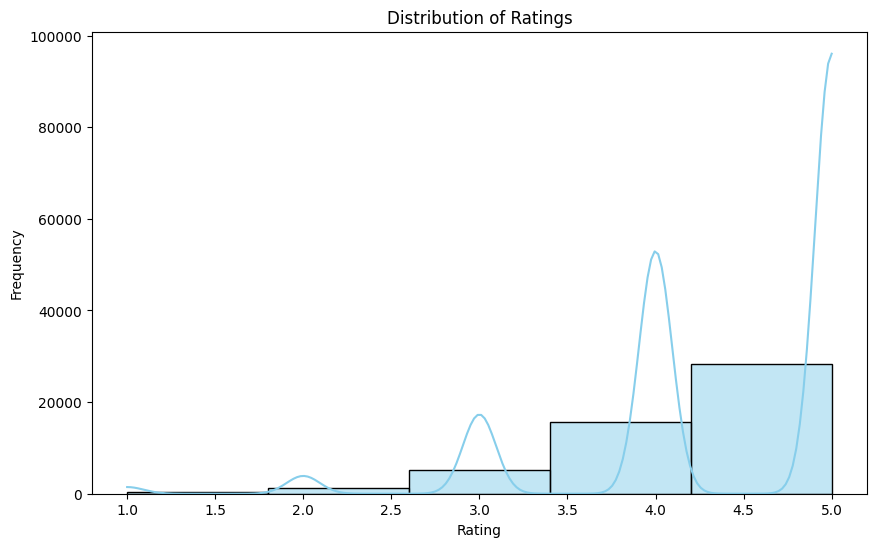

In [584]:
plt.figure(figsize=(10, 6))
sns.histplot(user_recipe_rating['rating'], bins=5, kde=True, color='skyblue')

# Adding labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')

# Display the plot
plt.show()

 Most of the recipes recieved higher ratings

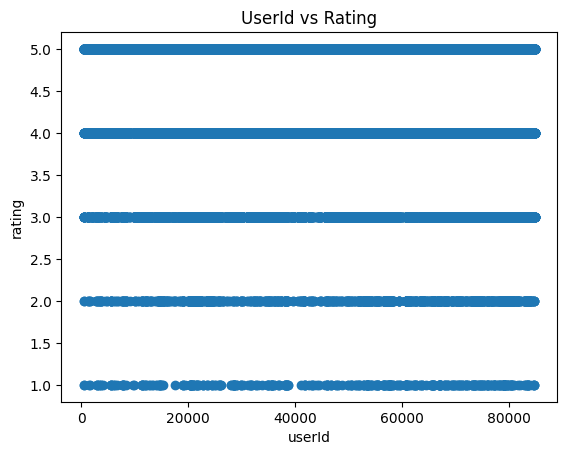

In [610]:
plt.scatter(user_recipe_rating['userID'], user_recipe_rating['rating'])
plt.xlabel('userId')
plt.ylabel('rating')
plt.title('UserId vs Rating')
plt.show()

- Top 10 recipes

/var/folders/vv/jld3_3hn5fz42wp20lz51yxm0000gn/T/ipykernel_48779/895671721.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Name', y='ratings_count', data=top_10_recipes, palette='pastel')


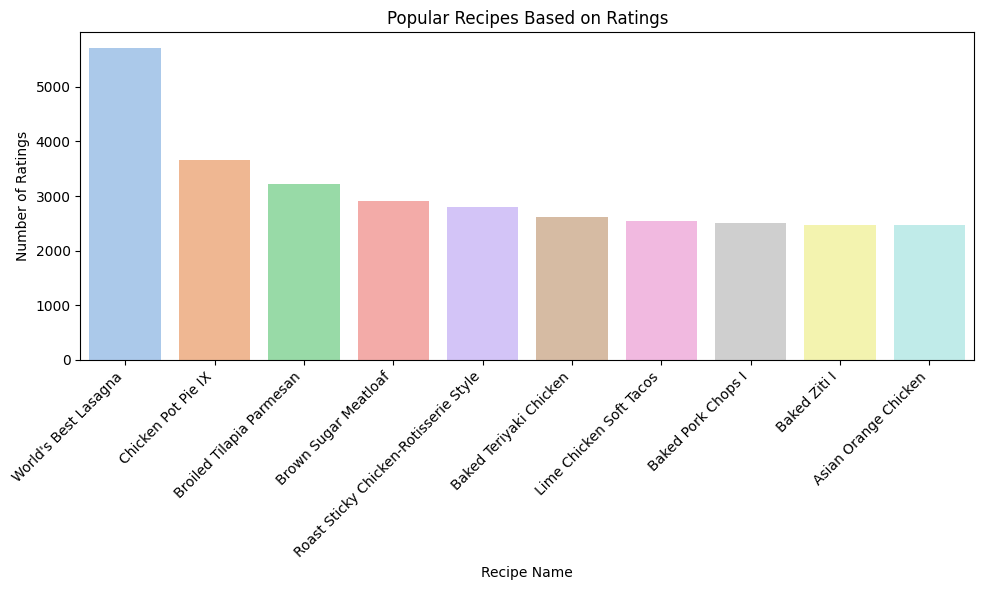

In [634]:
# Count ratings per recipeID
ratings_count = final_set.groupby('Name').size().reset_index(name='ratings_count')

# Sort by ratings_count in descending order
ratings_count = ratings_count.sort_values(by='ratings_count', ascending=False)

top_10_recipes = ratings_count[:10]

# Plotting popular recipes based on ratings count
plt.figure(figsize=(10, 6))
sns.barplot(x='Name', y='ratings_count', data=top_10_recipes, palette='pastel')
plt.xlabel('Recipe Name')
plt.ylabel('Number of Ratings')
plt.title('Popular Recipes Based on Ratings')
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment of xticks
plt.tight_layout()
plt.show()

### Singular Value Decomposition 

Singular value decomposition is a matrix factorization methods that composes a matrix into other matrices and used in recommendation systems to predict the missing ratings using the constructed matrices and vectors from the decomposition.


## import libraries 

